# Libraries

In [58]:
from ucimlrepo import fetch_ucirepo 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import seaborn as sns
import scipy.special

import seaborn as sns
import matplotlib.ticker as mtick

from skopt import gp_minimize
from skopt.space import Real, Categorical

from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    auc,
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    roc_auc_score
)

import arviz as az
import pymc as pm
from scipy.special import expit

import warnings
warnings.filterwarnings('ignore')

# Data Download

In [59]:
# fetch dataset 
dow_jones_index = fetch_ucirepo(id=312) 
  
# data (as pandas dataframes) 
X = dow_jones_index.data.features 
y = dow_jones_index.data.targets 

df = pd.concat([X,y], axis=1)

In [60]:
df

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,days_to_next_dividend,percent_return_next_dividend,percent_change_next_weeks_price
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,26,0.182704,-4.428490
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,19,0.187852,-2.470660
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,12,0.189994,1.638310
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5,0.185989,5.933250
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,97,0.175029,0.230814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2,XOM,5/27/2011,$80.22,$82.63,$80.07,$82.63,68230855,3.00424,-21.355713,86758820.0,$83.28,$81.18,75,0.568801,-2.521610
746,2,XOM,6/3/2011,$83.28,$83.75,$80.18,$81.18,78616295,-2.52161,15.221032,68230855.0,$80.93,$79.78,68,0.578960,-1.420980
747,2,XOM,6/10/2011,$80.93,$81.87,$79.72,$79.78,92380844,-1.42098,17.508519,78616295.0,$80.00,$79.02,61,0.589120,-1.225000
748,2,XOM,6/17/2011,$80.00,$80.82,$78.33,$79.02,100521400,-1.22500,8.811952,92380844.0,$78.65,$76.78,54,0.594786,-2.377620


# Data Preprocessing

In [61]:
# convert price-related cols to numeric
price_cols = ['open','high','low','close','next_weeks_open','next_weeks_close']
df[price_cols] = df[price_cols].replace('[\$,]', '', regex=True).astype(float)

# drop next week's data as it is data leakage
df.drop(columns=['percent_change_price','next_weeks_open','next_weeks_close','percent_return_next_dividend'], inplace=True)

# convert dates to numerical variable
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

df.drop(columns=['date'],inplace=True)
df.drop(columns=['year'], inplace=True) # since all is in the same year

df.dropna(inplace=True)

df['stock'] = LabelEncoder().fit_transform(df['stock'])

df['percent_change_next_weeks_price'] = (df['percent_change_next_weeks_price'] > 0).astype(int)
df.rename(columns={'percent_change_next_weeks_price': 'next_week_price_movement'}, inplace=True)

# Split features and target
X = df.drop(columns=["next_week_price_movement"])
y = df["next_week_price_movement"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Standardise numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

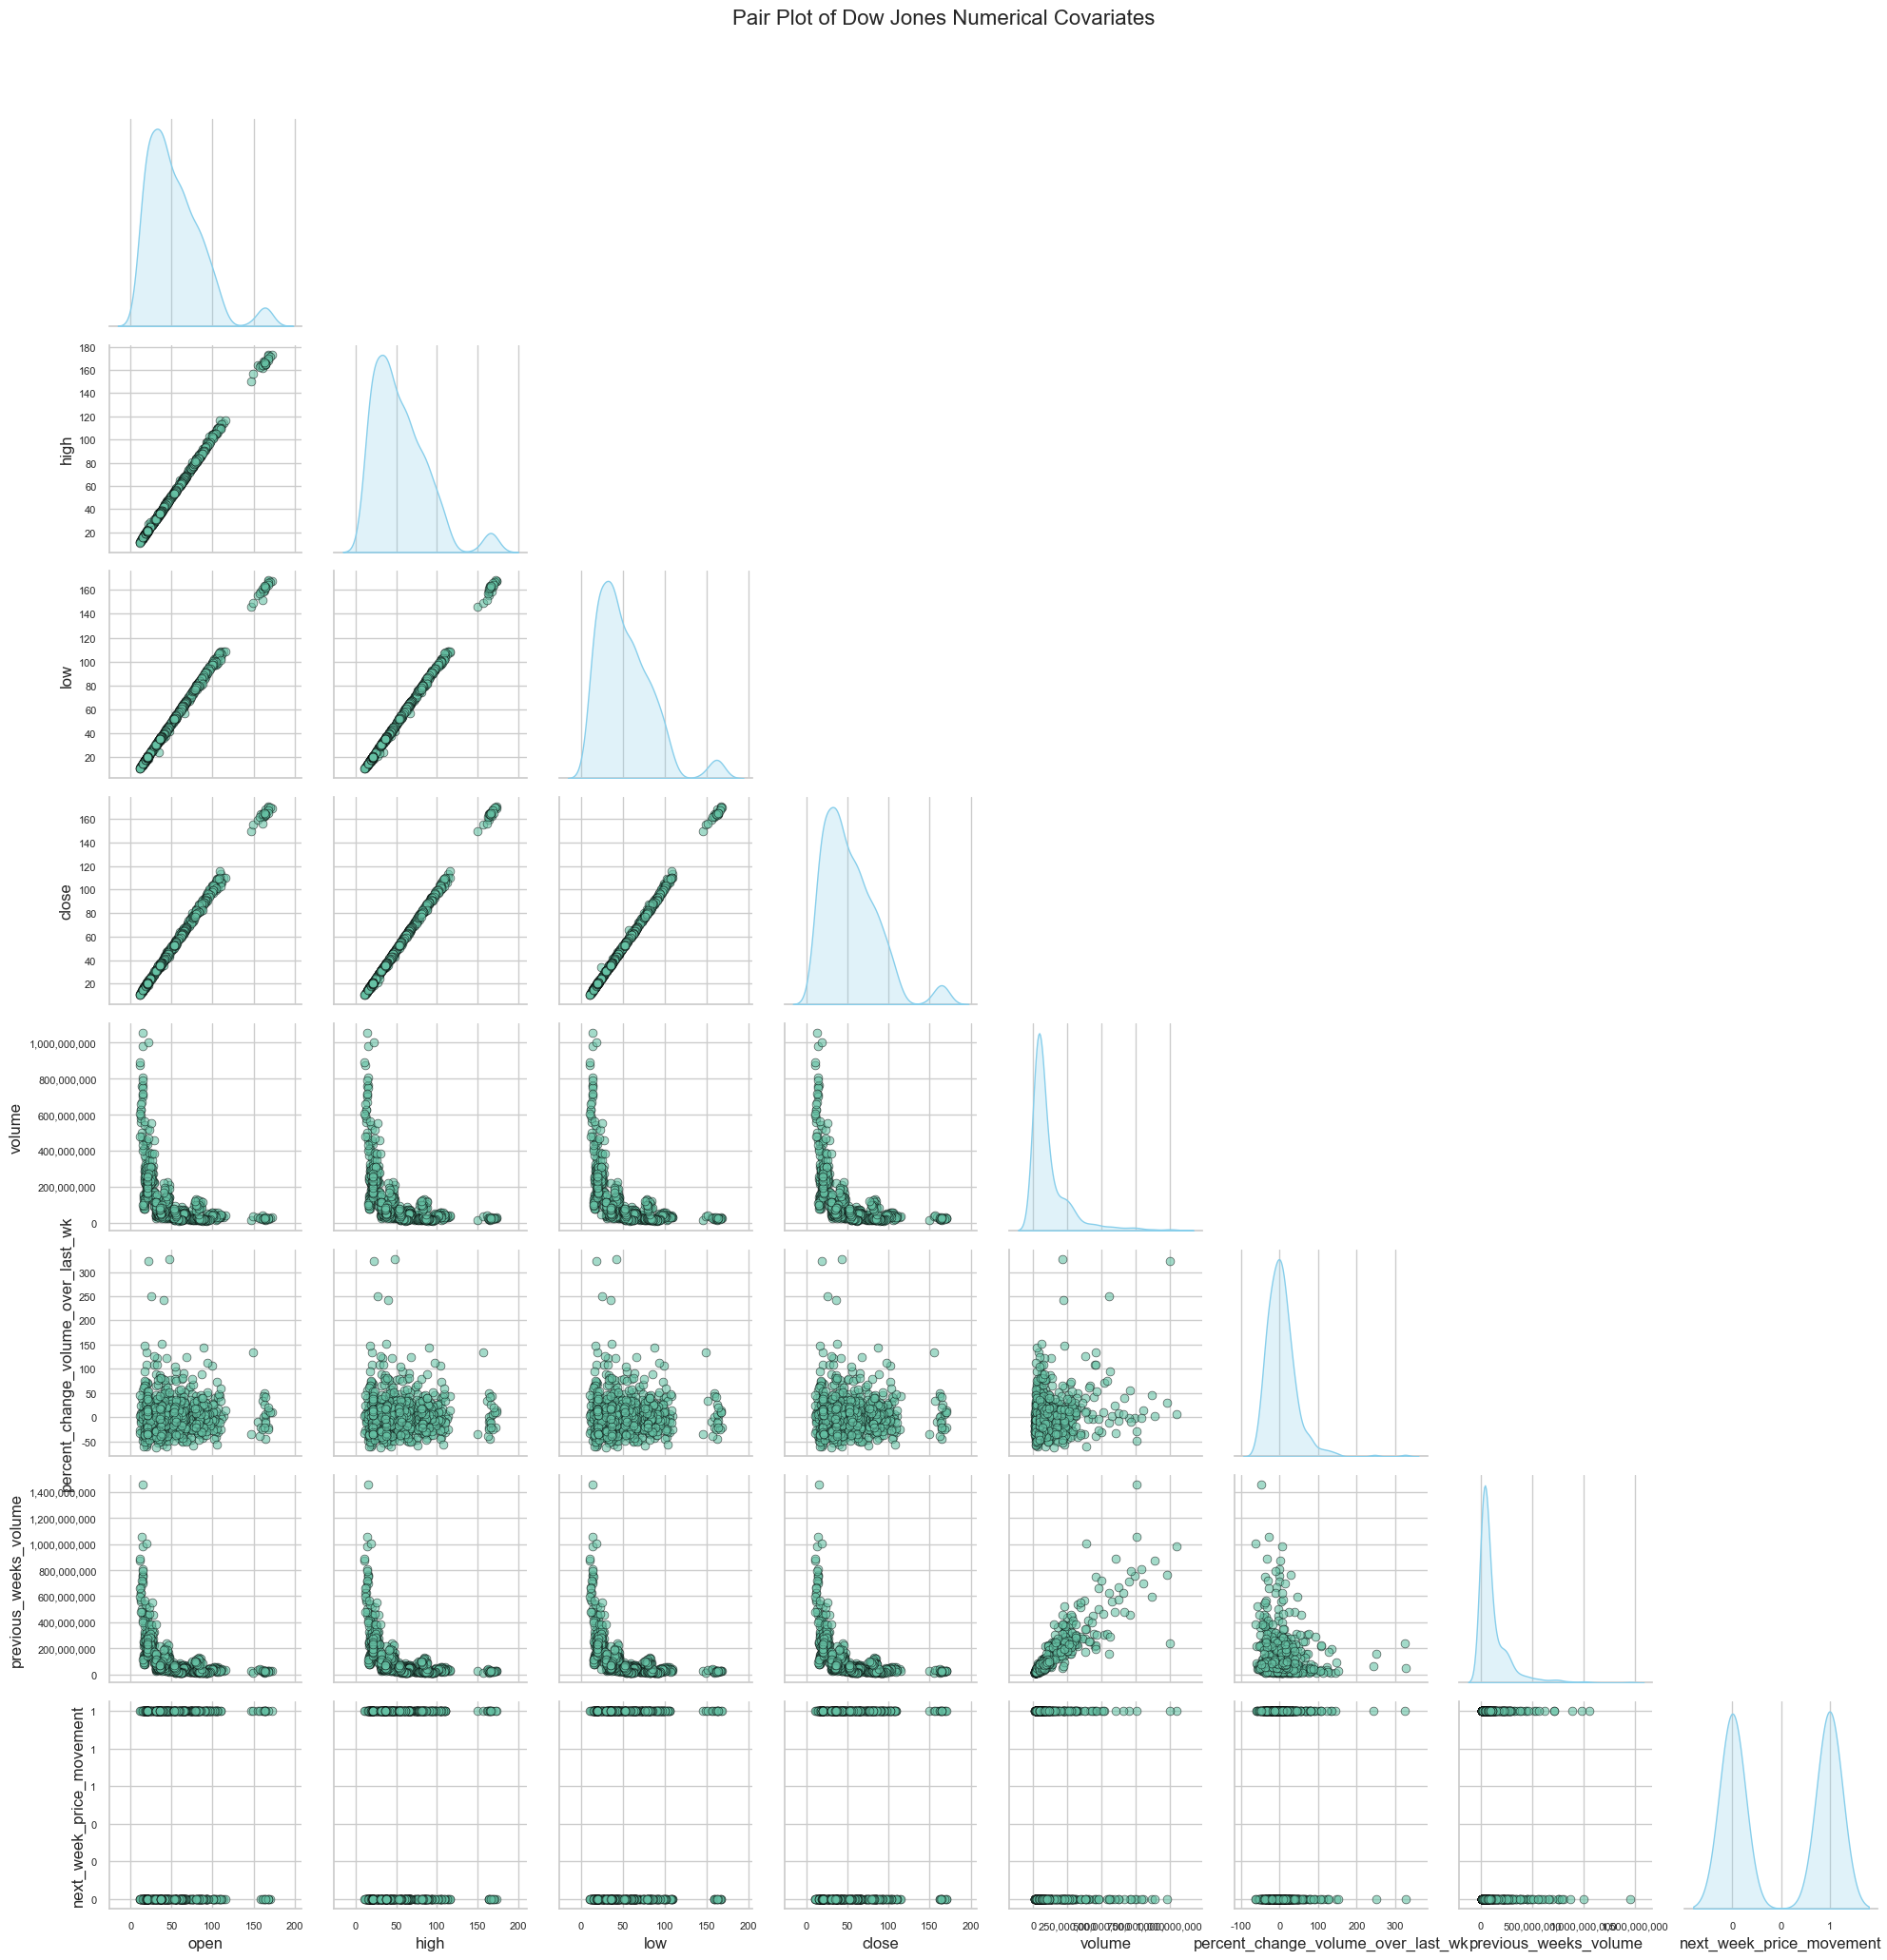

In [57]:
sns.set(style="whitegrid", context="notebook", palette="Set2")

numerical_cols = ['open','high','low','close','volume',
                  'percent_change_volume_over_last_wk',
                  'previous_weeks_volume','next_week_price_movement']

# Create the pairplot
pair_grid = sns.pairplot(df[numerical_cols],
                         diag_kind='kde',
                         corner=True,
                         plot_kws={'alpha': 0.6, 's': 40, 'edgecolor': 'k'},
                         diag_kws={'shade': True, 'color': 'skyblue'})

for ax in pair_grid.axes.flatten():
    if ax is not None:
        ax.tick_params(axis='both', labelsize=8)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:,.0f}'))

plt.suptitle("Pair Plot of Dow Jones Numerical Covariates", fontsize=16, y=1.03)

# Tight layout for spacing
plt.tight_layout()
#plt.savefig('dow_jones_pairsplot.png', dpi=600, bbox_inches='tight')
plt.show()

# Models

### 1. Logistic Regression - MLE

- Logistic Regression is a linear model for binary classification, predicting the probability of the target class using the logistic function (sigmoid)
- MLE approach estimates model parameter by maximising the likelihood function, measuring how well the model explains the observed data.
- It is simple and easy to interpret

The logistic regression model uses the sigmoid function $\sigma(\cdot) : (-\infty, -\infty) \rightarrow  (0,1) $ 

$$
\sigma(x, \beta) = \big( \frac{1}{1+e^{-x \beta}} \big)
$$

The given by the following formula:

\begin{align}
p( y=1| \beta,x) &= \prod_{i=1}^n f(x_n,\beta)^{y_n} \cdot [1-f(x_n,\beta)]^{(1-y_n)} \\
&= \prod_{i=1}^n f_n^{y_n} \cdot (1-f_n)^{(1-y_n)} \\
\end{align}

where we define for convenience of notation $f_n := f(x_n,\beta)$ .

Hence the negative log-likelihood (NLL) becomes
\begin{align}
-\log p( y=1| \beta,x) &= -\sum_{i=1}^n \{ y_n \log f_n + (1-y_n) \log(1-f_n) \}
\end{align}

The in-built Scikit-Learn LogisticRegression function, without initialising a penalty term, defaults to the MLE method and seeks to minimise the NLL.​


In [4]:
logistic_mle = LogisticRegression(max_iter=1000)
logistic_mle.fit(X_train_scaled, y_train)

# Prediction
y_pred_logistic_mle = logistic_mle.predict(X_test_scaled)
y_probs = logistic_mle.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for the positive class

# Accuracy and ROC
accuracy_logistic_mle = accuracy_score(y_test, y_pred_logistic_mle)
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# store information
fpr_dict = {}
tpr_dict = {}
acc_dict = {}
auc_dict = {}

fpr_dict['logistic_mle'] = fpr
tpr_dict['logistic_mle'] = tpr
acc_dict['logistic_mle'] = accuracy_logistic_mle
auc_dict['logistic_mle'] = roc_auc

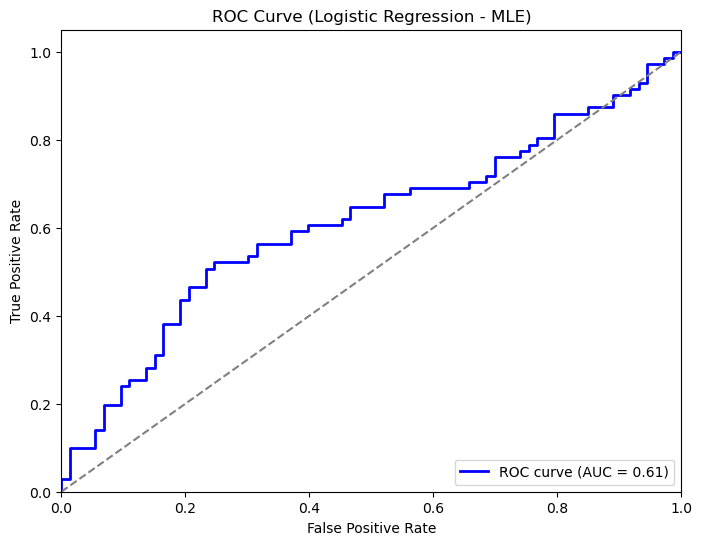

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression - MLE)')
plt.legend(loc='lower right')
plt.show()

In [6]:
print(f"Logistic Regression (MLE) Accuracy: {accuracy_logistic_mle:.4f}")

Logistic Regression (MLE) Accuracy: 0.5764


### 2. Bayesian Logistic Regression - Laplace Approximation

- This is a bayesian version of logistic regression that incorporates prior beliefes about parameters and uses Laplace approximation for posterior inference, analogous to the central limit theorem in the frequentist realm.
- Unlike MLE, Laplace approximation provides a bayesian framework by assuming a gaussian prior on coefficients.
- The posterior distribution is approximated using a gaussian distribution centered at the mode of the true posterior.
- This method is useful for uncertainty estimation.

Using Laplace approximation seeks to approximate the posterior $p(\beta | x, y)$ with a Gaussian. The Gaussian distribution is characterised by two parameters, the mean and the covariance. The mean $\beta_{\text{MAP}}$ is given by the MAP of the unormalized likelihood times prior, while the covariance is the Hessian evaluated $\beta_{\text{MAP}}$. 

Assume a Gaussian prior and get the following approximate posterior 

\begin{align}
\beta & \sim N(m_0, S_0^{-1}) \; \text{(prior)}\\
p(\beta|x,y) & \sim  N(\hat{\beta}, S^{-1})  \; \text{(posterior)}
\end{align}

where
\begin{align}
\beta_{\text{MAP}} & = \text{argmin}_{\beta} \log p(\beta|y,x), \; \log p(\beta|y,x) = \log p(y|\beta,x) + \log p(\beta) \\
S & = -\nabla^2 \log p(\beta|y,x) |_{\beta_{\text{MAP}}}
\end{align}

In [7]:
def nll(beta, x, y):
    t = y.T.dot(np.log(sigma(x,beta)))+ (1-y).T.dot(np.log(1.-sigma(x,beta)))
    return -t

def sigma(x,beta):
    xbeta = x.dot(beta)
    d = 1. + np.exp(-xbeta)
    return d**(-1)

def neg_post(beta, x, y, m0, S0):
    logprior =  - .5* (beta-m0).T @ S0 @ (beta-m0)
    return  nll(beta, x, y) -  logprior
def neg_post_prime(beta, x, y, m0, S0):
    return  x.T.dot(sigma(x,beta)-y)+S0.dot(beta-m0)
    
def laplace_prec(beta, x, S0):
    n = x.shape[0]  
    S = np.diag(sigma(x,beta)*(1-sigma(x,beta)))
    prec = S0.values + x.T.dot(S.dot(x))    
    return prec
def NewtonRaphsonBayesLogReg(beta0,x,y,m0,S0,maxiter,tolerance):
    i = 0
    beta = beta0
    NegLogPost = neg_post(beta, x, y, m0, S0)
    AbDiff = 1; #anything bigger than tolerance would do here
    while (AbDiff> tolerance) & (i<maxiter):
        i =i+1;
        print('iteration ',i,' Negative Log Posterior ',NegLogPost, ' AbDiff ', AbDiff)
        grad = neg_post_prime(beta, x, y, m0, S0)
        H = laplace_prec(beta, x, S0)        
        H_inv = sc.linalg.inv(H) 
        beta = beta - H_inv.dot(grad)
        NegLogPost_new = neg_post(beta, x, y, m0, S0)
        AbDiff = np.abs(NegLogPost_new-NegLogPost)
        NegLogPost = NegLogPost_new
    if (iter == maxiter):
        print('Did not Converge') 
    return beta, H_inv

In [8]:
Xt = pd.DataFrame(X_train_scaled, index=y_train.index, columns=X_train.columns)

n,p = Xt.shape
m0 = np.zeros(p)
S0 = Xt.T.dot(Xt)/n
beta0 = np.zeros(p)
tolerance = 1e-05
maxiter = 100 
beta_map, cov = NewtonRaphsonBayesLogReg(beta0, Xt, y_train,
                                                  m0,S0,maxiter,tolerance)
#print(beta_map)
#cov

iteration  1  Negative Log Posterior  399.2527760025285  AbDiff  1
iteration  2  Negative Log Posterior  388.64949408199186  AbDiff  10.60328192053663
iteration  3  Negative Log Posterior  388.61127585306275  AbDiff  0.038218228929110865


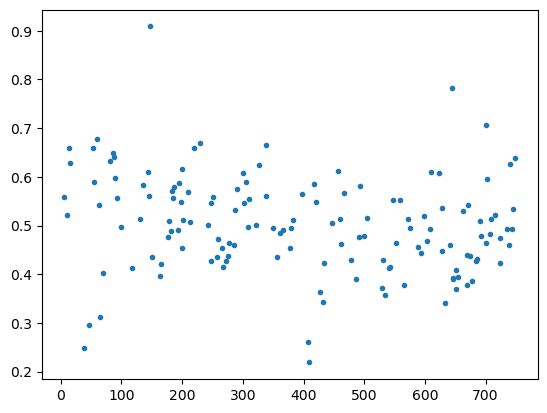

In [9]:
#Calculate the prediction probabilities with Bayesian Logistic regression

Xt_test = pd.DataFrame(X_test_scaled, index = y_test.index, columns = X_test.columns)

N = 1000 #number of Monte Carlo samples
# draw N samples from the approximate posterior (Laplace) of beta
betas = np.random.multivariate_normal(beta_map,cov,N)
Xbetas = Xt_test.dot(betas.T)
#apply sigmoid
d = 1/(1. + np.exp(-Xbetas))
pred_probs_blr = np.mean(d, axis=1)
plt.plot(pred_probs_blr,'.')

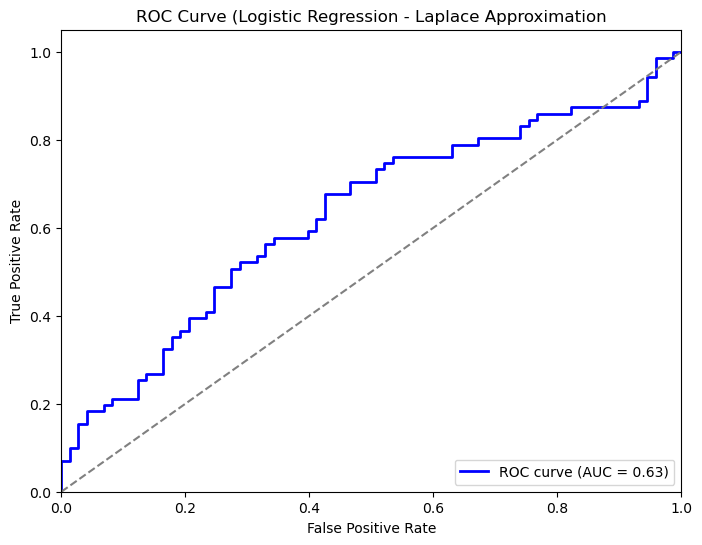

In [10]:
#Evaluate predictive performance of Bayesian Logistic Regression

pred_class_blr = (pred_probs_blr > .5)
pred_class_blr = pred_class_blr * 1

# Accuracy and ROC
fpr,tpr, _ = roc_curve(y_test,pred_probs_blr)
roc_auc = auc(fpr, tpr)
accuracy_logistic_laplace = accuracy_score(y_test, pred_class_blr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression - Laplace Approximation')
plt.legend(loc='lower right')
plt.show()

fpr_dict['logistic_laplace'] = fpr
tpr_dict['logistic_laplace'] = tpr
acc_dict['logistic_laplace'] = accuracy_logistic_laplace
auc_dict['logistic_laplace'] = roc_auc

In [11]:
print(f"Logistic Regression (Laplace Approx) Accuracy: {accuracy_logistic_laplace:.4f}")

Logistic Regression (Laplace Approx) Accuracy: 0.5972


### 3. Bayesian Logistic Regression - Automatic Differentiation Variational Inference (ADVI)

This model implements **Bayesian Logistic Regression** using **PyMC** and **Automatic Differentiation Variational Inference (ADVI)** for approximate posterior inference.

### 1. Priors

- Intercept:

$$
\alpha \sim \mathcal{N}(0, 1)
$$

- Coefficients (with hierarchical prior):

$$
\tau \sim \text{HalfNormal}(\sigma=5)
$$

$$
\boldsymbol{\beta} \sim \mathcal{N}(0, \tau^2 I)
$$

### 2. Linear Combination

The linear predictor (logits):

$$
\mu_i = \alpha + \mathbf{x}_i^T \boldsymbol{\beta}
$$

### 3. Likelihood

We model each binary outcome using a Bernoulli distribution with a probability given by the logistic sigmoid of the linear predictor:

$$
p_i = \sigma(\mu_i) = \frac{1}{1 + \exp(-\mu_i)}
$$

$$
y_i \sim \text{Bernoulli}(p_i)
$$

Equivalently, the likelihood for a single data point can be written as:

$$
p(y_i \mid \mathbf{x}_i, \alpha, \boldsymbol{\beta}) = \left( \frac{1}{1 + \exp(-\mu_i)} \right)^{y_i} \left( 1 - \frac{1}{1 + \exp(-\mu_i)} \right)^{1 - y_i}
$$

And the full-data likelihood:

$$
p(\mathbf{y} \mid \mathbf{X}, \alpha, \boldsymbol{\beta}) = \prod_{i=1}^{N} \sigma(\mu_i)^{y_i} \left(1 - \sigma(\mu_i)\right)^{1 - y_i}
$$

### 4. Variational Inference (ADVI)

Shown below utilising **PyMC**

In [12]:
Xt = pd.DataFrame(X_train_scaled, index=y_train.index, columns=X_train.columns)

In [13]:
basic_model = pm.Model()

with basic_model as logistic_regression_model:
    x = pm.Data("x", Xt)

    # hyperprior for sigma (tau)
    tau = pm.HalfNormal('tau', sigma=5)
    
    # Priors (tighter priors for better convergence)
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma= tau, shape=Xt.shape[1])

    # Expected value of outcome
    mu = alpha + pm.math.dot(x, beta)
    p = pm.Deterministic("p", pm.math.sigmoid(mu))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli("y", p=p, observed=y_train)

In [14]:
with logistic_regression_model:
    mean_field = pm.fit(n=10000, method='advi', progressbar=True)

Output()

Finished [100%]: Average Loss = 439.08


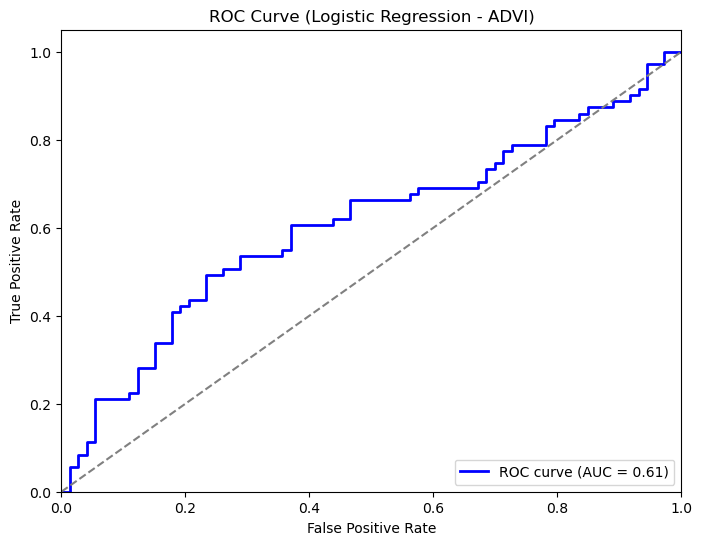

In [15]:
# Sample from the ADVI posterior
posterior_trace = mean_field.sample(1000)

# Manually compute predicted probabilities
alpha_samples = posterior_trace.posterior["alpha"].values.flatten()
beta_samples = posterior_trace.posterior["beta"].values

mu = alpha_samples[:, None] + np.dot(beta_samples, X_test_scaled.T)
p_samples = scipy.special.expit(mu)
p_samples = np.squeeze(p_samples)

p_pred = p_samples.mean(axis=0)  # average over posterior draws

pred_class_advi = (p_pred > .5)
pred_class_advi = pred_class_advi * 1

# Accuracy and ROC
fpr,tpr, _ = roc_curve(y_test,p_pred)
roc_auc = auc(fpr, tpr)
accuracy_logistic_advi = accuracy_score(y_test, pred_class_advi)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression - ADVI)')
plt.legend(loc='lower right')
plt.show()

fpr_dict['logistic_advi'] = fpr
tpr_dict['logistic_advi'] = tpr
acc_dict['logistic_advi'] = accuracy_logistic_advi
auc_dict['logistic_advi'] = roc_auc

In [16]:
print(f"Logistic Regression (ADVI) Accuracy: {accuracy_logistic_advi:.4f}")

Logistic Regression (ADVI) Accuracy: 0.5903


### 4. Quadratic Discriminant Analysis

- QDA is a probabilistic classifier that models each class as a gaussian distribution with its own covariance matrix.
- QDA relaxes the assumption of equal class covariances (unlike LDA), allowing for more flexible decision boundaries.
- It works well when classes have distinct covariance structures.

### 1. Assumptions

- Each class \( k \) follows a multivariate normal distribution:

$$
\mathbf{x} \mid y = k \sim \mathcal{N}(\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)
$$

- Class prior probabilities:

$$
P(y = k) = \pi_k
$$

### 2. Class-Conditional Densities

$$
p(\mathbf{x} \mid y = k) = \frac{1}{(2\pi)^{d/2} |\boldsymbol{\Sigma}_k|^{1/2}} \exp\left( -\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu}_k)^T \boldsymbol{\Sigma}_k^{-1} (\mathbf{x} - \boldsymbol{\mu}_k) \right)
$$

### 3. Posterior Using Bayes’ Rule

$$
P(y = k \mid \mathbf{x}) = \frac{p(\mathbf{x} \mid y = k) \, \pi_k}{\sum_{j=1}^{K} p(\mathbf{x} \mid y = j) \, \pi_j}
$$

### 4. Discriminant Function and Decision Boundaries

The discriminant function for class \( k \) is:

$$
\delta_k(\mathbf{x}) = -\frac{1}{2} \log |\boldsymbol{\Sigma}_k| - \frac{1}{2} (\mathbf{x} - \boldsymbol{\mu}_k)^T \boldsymbol{\Sigma}_k^{-1} (\mathbf{x} - \boldsymbol{\mu}_k) + \log \pi_k
$$

Prediction rule:

$$
\hat{y} = \arg\max_k \delta_k(\mathbf{x})
$$

Because each class has its own covariance matrix \( \boldsymbol{\Sigma}_k \), the decision boundaries are **quadratic**.

In [17]:
# QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)

# Predictions and probabilities
y_pred = qda.predict(X_test_scaled)
pred_probs_qda = qda.predict_proba(X_test_scaled)[:, 1]  # Probability for class 1

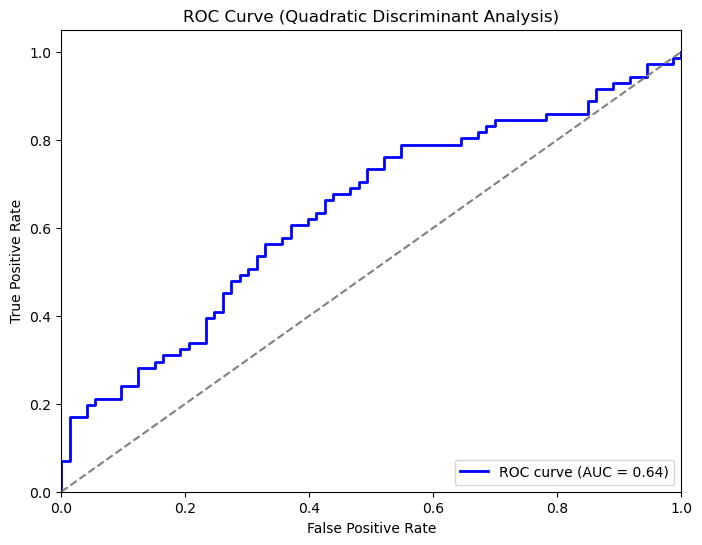

In [18]:
# Accuracy and ROC
fpr,tpr, _ = roc_curve(y_test,pred_probs_qda)
roc_auc = auc(fpr, tpr)
accuracy_qda = accuracy_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Quadratic Discriminant Analysis)')
plt.legend(loc='lower right')
plt.show()

fpr_dict['qda'] = fpr
tpr_dict['qda'] = tpr
acc_dict['qda'] = accuracy_qda
auc_dict['qda'] = roc_auc

In [19]:
print(f"Quadratic Discriminant Analysis Accuracy: {accuracy_qda:.4f}")

Quadratic Discriminant Analysis Accuracy: 0.5972


### 5. Naive Bayes Classifier

- Gaussian NB is a probabilistic classifier based on Bayes' theorem with the "naive" assumption of feature independence
- Despite being simple, Gaussian NB is effective for high-dimensionality data.
- It models each feature as a Gaussian distribution per class and is computationally efficient.

### 1. Assumptions

- The features \( x_1, x_2, \dots, x_d \) are **conditionally independent** given the class label \( y \).
- Each class has a prior probability:

$$
P(y = k) = \pi_k
$$

### 2. Class-Conditional Densities

Under the naive assumption:

$$
p(\mathbf{x} \mid y = k) = \prod_{j=1}^{d} p(x_j \mid y = k)
$$

If features are modeled as Gaussians (Gaussian Naive Bayes):

$$
x_j \mid y = k \sim \mathcal{N}(\mu_{kj}, \sigma_{kj}^2)
$$

Then:

$$
p(x_j \mid y = k) = \frac{1}{\sqrt{2\pi \sigma_{kj}^2}} \exp\left( -\frac{(x_j - \mu_{kj})^2}{2\sigma_{kj}^2} \right)
$$

### 3. Posterior Using Bayes’ Rule

Using the naive assumption:

$$
P(y = k \mid \mathbf{x}) = \frac{p(\mathbf{x} \mid y = k) \, \pi_k}{\sum_{j=1}^{K} p(\mathbf{x} \mid y = j) \, \pi_j}
$$

### 4. Discriminant Function and Decision Rule

We typically use the log of the posterior (to avoid numerical underflow):

$$
\log P(y = k \mid \mathbf{x}) = \log \pi_k + \sum_{j=1}^d \log p(x_j \mid y = k) + C
$$

Classification rule:

$$
\hat{y} = \arg\max_k \log P(y = k \mid \mathbf{x})
$$

Decision boundaries are **non-linear** and depend on the form of \( p(x_j \mid y = k) \), but are often piecewise linear or quadratic.


In [20]:
# Train Naive Bayes (Gaussian)
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

# Predict and Evaluate
y_pred = nb.predict(X_test_scaled)
pred_probs_nb = nb.predict_proba(X_test_scaled)[:, 1]

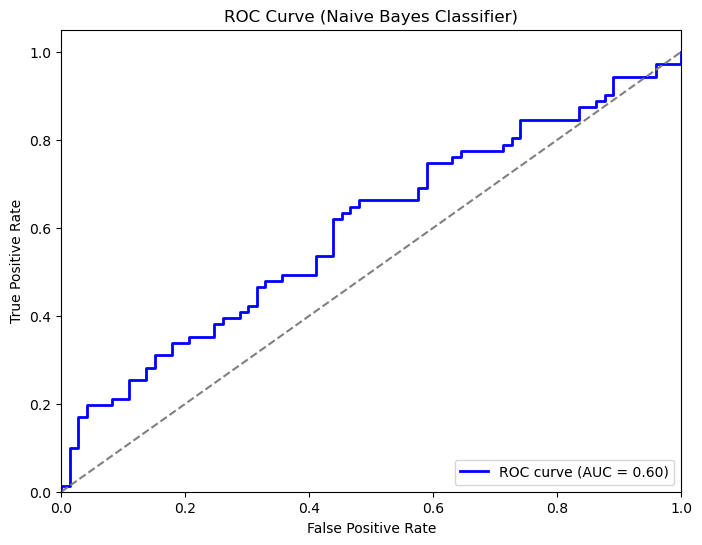

In [21]:
# Accuracy and ROC
fpr,tpr, _ = roc_curve(y_test,pred_probs_nb)
roc_auc = auc(fpr, tpr)
accuracy_nb = accuracy_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Naive Bayes Classifier)')
plt.legend(loc='lower right')
plt.show()

fpr_dict['nb'] = fpr
tpr_dict['nb'] = tpr
acc_dict['nb'] = accuracy_nb
auc_dict['nb'] = roc_auc

In [22]:
print(f"Gaussian NB Accuracy: {accuracy_nb:.4f}")

Gaussian NB Accuracy: 0.5347


### 6. Gaussian Process Classification

- Gaussian Process Classification is a non-parametric model that uses Gaussian Processes (GPs) for classification by transforming the output of a GP into a probability using the logistic function.
- GPs model the data as a distribution over functions, capturing complex relationships without assuming a fixed functional form.
- A lot of the model's performance is reliant on the choice of covariance kernel, which defines the covariance structure.
- It is flexible but computationally expensive as we have to perform optimisation on the best covariance kernel. 

#### Assumptions
- The latent function follows a Gaussian Process prior:
  $$
  f(\mathbf{x}) \sim \mathcal{GP}(0, k(\mathbf{x}, \mathbf{x'}))
  $$
  where \( k \) is a positive-definite covariance (kernel) function.
  
- We will optimise the choice of covariance kernel via bayesian optimisation from a list of space and different kernels.

#### Class Conditional Densities
- The probability of the binary class label is modeled using a logistic (sigmoid) link on the latent function:
  $$
  P(y = 1 \mid \mathbf{x}) = \sigma(f(\mathbf{x})) = \frac{1}{1 + e^{-f(\mathbf{x})}}
  $$

#### Posterior Inference (Laplace Approximation)
- The non-Gaussian likelihood (Bernoulli) makes exact inference intractable.
- We approximate the posterior over the latent function \( f \) using a **Laplace approximation**:
  $$
  p(f \mid \mathcal{D}) \approx \mathcal{N}(\hat{f}, A^{-1})
  $$
  where \( \hat{f} \) is the mode of the posterior and \( A \) is the Hessian of the negative log posterior.
  this is done so in the sklearn.GaussianProcessClassifier. 

#### Discriminant Function & Decision Rule
- Class predictions are made by thresholding the predictive probability:
  $$
  \hat{y} = 
  \begin{cases}
  1 & \text{if } P(y = 1 \mid \mathbf{x}) > 0.5 \\
  0 & \text{otherwise}
  \end{cases}
  $$

In [23]:
space = [
    Categorical(['RBF', 'Matern', 'RationalQuadratic','RBF+Matern','RBF+RQ'], name='kernel_type'),
    Real(1e-2, 1e2, prior='log-uniform', name='length_scale'),
    Real(0.1, 10.0, name='constant_value'),
    Real(1e-5, 1.0, prior='log-uniform', name='noise_level'),

    Real(0.1, 10.0, prior='log-uniform', name='alpha'), # for RationalQuadratic
    Categorical([0.5,1.5,2.5], name='nu')               # for Matern
]

In [28]:
def make_kernel(kernel_type, length_scale, constant_value, noise_level, alpha, nu):
    if kernel_type == 'RBF':
        base = RBF(length_scale=length_scale)
    elif kernel_type == 'Matern':
        base = Matern(length_scale=length_scale, nu=nu)
    elif kernel_type == 'RationalQuadratic':
        base = RationalQuadratic(length_scale=length_scale, alpha=alpha)
    elif kernel_type == 'RBF+Matern':
        base = RBF(length_scale=length_scale) + Matern(length_scale=length_scale, nu=nu)
    elif kernel_type == 'RBF+RQ':
        base = RBF(length_scale=length_scale) + RationalQuadratic(length_scale=length_scale, alpha=alpha)
    else:
        raise ValueError("Unknown Kernel Type")
    
    # Composite kernel with Constant and White noise
    return C(constant_value) * (base + WhiteKernel(noise_level=noise_level))

def objective(params):
    kernel_type, length_scale, constant_value, noise_level, alpha, nu  = params
    kernel = make_kernel(kernel_type, length_scale, constant_value, noise_level, alpha, nu)
    
    gpc = GaussianProcessClassifier(kernel=kernel, random_state=0, max_iter_predict=100)
    
    # Use k-fold cross-validation
    score = cross_val_score(gpc, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    
    return -score  # Minimize negative accuracy


In [29]:
# Bayesian Optimisation
result = gp_minimize(
    func=objective,
    dimensions=space,
    acq_func='EI',      # Expected Improvement
    n_calls=100,         # Number of evaluations
    n_initial_points=10,
    random_state=0,
    verbose=True
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 10.1019
Function value obtained: -0.4896
Current minimum: -0.4896
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.7783
Function value obtained: -0.5296
Current minimum: -0.5296
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.3287
Function value obtained: -0.4983
Current minimum: -0.5296
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 8.5113
Function value obtained: -0.4931
Current minimum: -0.5296
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 5.2194
Function value obtained: -0.5017
Current minimum: -0.5296
Iteration No: 6 started.

In [30]:
best_params = result.x
best_kernel = make_kernel(*best_params)
print(best_kernel)

2.83**2 * RBF(length_scale=0.0255) + WhiteKernel(noise_level=0.00309)


In [31]:
gp = GaussianProcessClassifier(kernel=best_kernel)

gp.fit(X_train_scaled, y_train)

GaussianProcessClassifier(kernel=2.83**2 * RBF(length_scale=0.0255) + WhiteKernel(noise_level=0.00309))

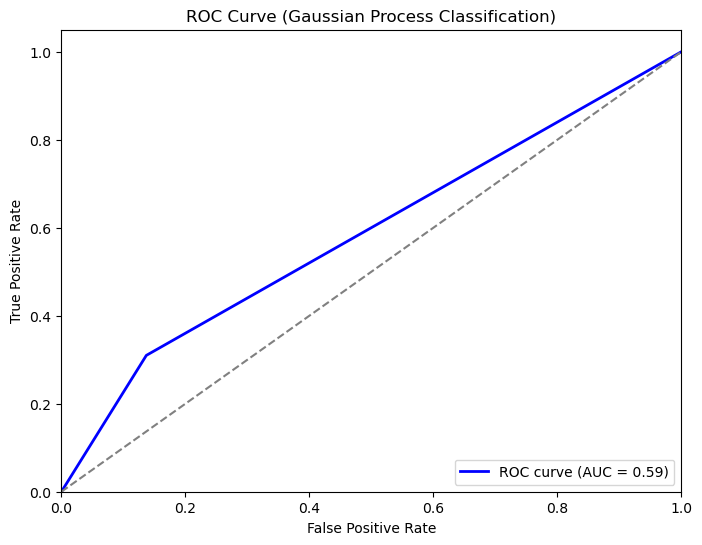

In [32]:
# Make predictions on the test data
y_pred = gp.predict(X_test_scaled)

# Accuracy
accuracyGP = accuracy_score(y_test, y_pred)

fpr,tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Gaussian Process Classification)')
plt.legend(loc='lower right')
plt.show()

fpr_dict['GP'] = fpr
tpr_dict['GP'] = tpr
acc_dict['GP'] = accuracyGP
auc_dict['GP'] = roc_auc

In [33]:
print(f"Gaussian Process Classification Accuracy: {accuracyGP:.4f}")

Gaussian Process Classification Accuracy: 0.5903


# Comparison of Models - Results

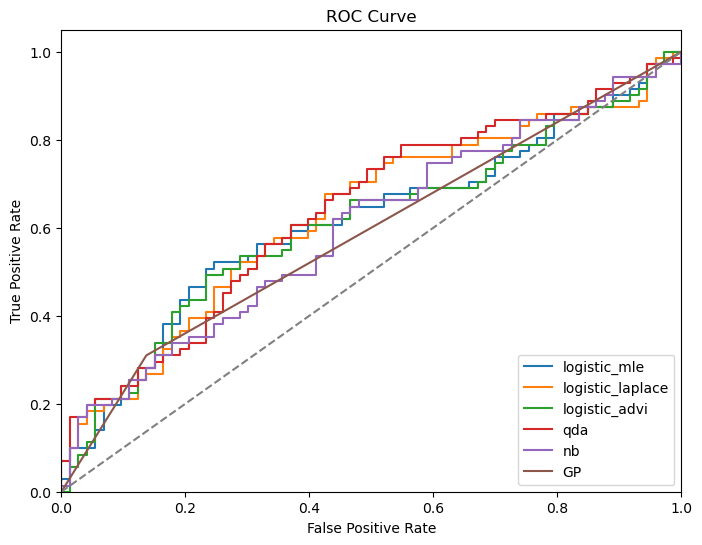

In [34]:
plt.figure(figsize=(8, 6))

# Plot each model's ROC curve
for key in fpr_dict.keys():
    plt.plot(fpr_dict[key], tpr_dict[key], label=f'{key}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [35]:
# Class balance (as a benchmark)
class_distribution = y_test.value_counts(normalize=True)
majority_class_rate = class_distribution.max()  # accuracy from always guessing the majority class

results_df = pd.DataFrame({
    "AUC (%)": auc_dict,
    "Accuracy (%)": acc_dict
})


results_df.loc["Baseline"] = {
    "AUC (%)": 0.5,
    "Accuracy (%)": majority_class_rate
}

results_df = results_df * 100

results_df = results_df.round(1).sort_values(by='AUC (%)', ascending=False)

results_df

,AUC (%),Accuracy (%)
qda,63.7,59.7
logistic_laplace,62.8,59.7
logistic_mle,61.1,57.6
logistic_advi,60.8,59.0
nb,59.8,53.5
GP,58.6,59.0
Baseline,50.0,50.7
